# Section 1: Preliminaries

## Section 1.1: Packages

We start by importing the necessary libraries.

In [1]:
# base packages to indicate where files are
import os
import sys

# package to set the seed
import random

# unused packages from 10x Visium tutorial
# import STAGATE
# import tensorflow as tf

# packages to load and work with data
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# packages for clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

# packages for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.manifold import Isomap

# initialize R
os.environ['R_HOME'] = 'C:\\Program Files\\R\\R-4.4.3'
os.environ['R_USER'] = 'C:\\Users\\jeffr\\anaconda3\\Lib\\site-packages\\rpy2'

Before we proceed, let us set a seed so that we can maintain reproducibility.

In [2]:
random.seed(6517)

## Section 1.2: Data Familiarization, Visualization, and Normalization

Now, we need to load in the data, along with the ground truth. We will work from the filtered data, so we do not have to preprocess as much. However, we do perform normalization on the counts; first, the sum of the counts for each cell is adjusted to be 10,000, after which, the counts are log-normalized. (Notice that this procedure preserves which counts in which cells are zero, so dropouts are maintained.) The transcripts that have the most variance are also noted down.

This procedure comes from the [10x Visium tutorial](https://stagate.readthedocs.io/en/latest/T1_DLPFC.html) given in the project description. The code below condenses what is used in that tutorial.

In [3]:
# load in the filtered data
input_dir = os.path.join('data\\151676')
adata_raw = sc.read_visium(path=input_dir, count_file='151676_filtered_feature_bc_matrix.h5')
adata_raw.var_names_make_unique()

adata = adata_raw.copy()

# note which transcripts have the greatest variance, and normalize the data
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# load in the ground truth
Ann_df = pd.read_csv(os.path.join(input_dir, '151676_ground_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

# check what our annotated data looks like
adata

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\1804147221.py:3: FutureWarning: Use `squidpy.read.visium` instead.
  adata_raw = sc.read_visium(path=input_dir, count_file='151676_filtered_feature_bc_matrix.h5')
C:\Users\jeffr\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\jeffr\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'

What this indicates is that there are 3460 cells with 33538 transcripts' expression data. Let's take a quick look at the ground truth of the types of cells.

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\3343155483.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])


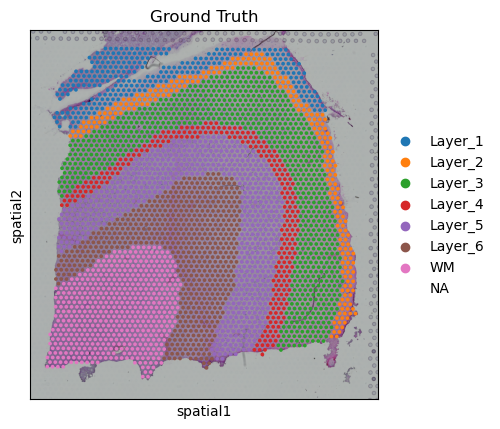

In [4]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

To get a quick view of the expression data, we convert `adata` to a `pandas.DataFrame`.

In [5]:
pdata = adata.to_df()
pdata

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  \
AAACAAGTATCTCCCA-1          0.0      0.0    0.0         0.0         0.0   
AAACAATCTACTAGCA-1          0.0      0.0    0.0         0.0         0.0   
AAACACCAATAACTGC-1          0.0      0.0    0.0         0.0         0.0   
AAACAGAGCGACTCCT-1          0.0      0.0    0.0         0.0         0.0   
AAACAGGGTCTATATT-1          0.0      0.0    0.0         0.0         0.0   
...                         ...      ...    ...         ...         ...   
TTGTTGTGTGTCAAGA-1          0.0      0.0    0.0         0.0         0.0   
TTGTTTCACATCCAGG-1          0.0      0.0    0.0         0.0         0.0   
TTGTTTCATTAGTCTA-1          0.0      0.0    0.0         0.0         0.0   
TTGTTTCCATACAACT-1          0.0      0.0    0.0         0.0         0.0   
TTGTTTGTGTAAATTC-1          0.0      0.0    0.0         0.0         0.0   

                    AL627309.2  AL627309.4  AL732372.1  OR4F29  AC114498.1  \
AAACAAGTATCTCCCA-1         0.0         0.0         0.0     0.0         0.0   
AAACAATCTACTAGCA-1         0.0         0.0         0.0     0.0         0.0   
AAACACCAATAACTGC-1         0.0         0.0         0.0     0.0         0.0   
AAACAGAGCGACTCCT-1         0.0         0.0         0.0     0.0         0.0   
AAACAGGGTCTATATT-1         0.0         0.0         0.0     0.0         0.0   
...                        ...         ...         ...     ...         ...   
TTGTTGTGTGTCAAGA-1         0.0         0.0         0.0     0.0         0.0   
TTGTTTCACATCCAGG-1         0.0         0.0         0.0     0.0         0.0   
TTGTTTCATTAGTCTA-1         0.0         0.0         0.0     0.0         0.0   
TTGTTTCCATACAACT-1         0.0         0.0         0.0     0.0         0.0   
TTGTTTGTGTAAATTC-1         0.0         0.0         0.0     0.0         0.0   

                    ...  AC007325.2  BX072566.1  AL354822.1  AC023491.2  \
AAACAAGTATCTCCCA-1  ...         0.0         0.0         0.0         0.0   
AAACAATCTACTAGCA-1  ...         0.0         0.0         0.0         0.0   
AAACACCAATAACTGC-1  ...         0.0         0.0         0.0         0.0   
AAACAGAGCGACTCCT-1  ...         0.0         0.0         0.0         0.0   
AAACAGGGTCTATATT-1  ...         0.0         0.0         0.0         0.0   
...                 ...         ...         ...         ...         ...   
TTGTTGTGTGTCAAGA-1  ...         0.0         0.0         0.0         0.0   
TTGTTTCACATCCAGG-1  ...         0.0         0.0         0.0         0.0   
TTGTTTCATTAGTCTA-1  ...         0.0         0.0         0.0         0.0   
TTGTTTCCATACAACT-1  ...         0.0         0.0         0.0         0.0   
TTGTTTGTGTAAATTC-1  ...         0.0         0.0         0.0         0.0   

                    AC004556.1  AC233755.2  AC233755.1  AC240274.1  \
AAACAAGTATCTCCCA-1         0.0         0.0         0.0         0.0   
AAACAATCTACTAGCA-1         0.0         0.0         0.0         0.0   
AAACACCAATAACTGC-1         0.0         0.0         0.0         0.0   
AAACAGAGCGACTCCT-1         0.0         0.0         0.0         0.0   
AAACAGGGTCTATATT-1         0.0         0.0         0.0         0.0   
...                        ...         ...         ...         ...   
TTGTTGTGTGTCAAGA-1         0.0         0.0         0.0         0.0   
TTGTTTCACATCCAGG-1         0.0         0.0         0.0         0.0   
TTGTTTCATTAGTCTA-1         0.0         0.0         0.0         0.0   
TTGTTTCCATACAACT-1         0.0         0.0         0.0         0.0   
TTGTTTGTGTAAATTC-1         0.0         0.0         0.0         0.0   

                    AC213203.1  FAM231C  
AAACAAGTATCTCCCA-1         0.0      0.0  
AAACAATCTACTAGCA-1         0.0      0.0  
AAACACCAATAACTGC-1         0.0      0.0  
AAACAGAGCGACTCCT-1         0.0      0.0  
AAACAGGGTCTATATT-1         0.0      0.0  
...                        ...      ...  
TTGTTGTGTGTCAAGA-1         0.0      0.0  
TTGTTTCACATCCAGG-1         0.0      0.0  
TTGTTTCATTAGTCTA-1         0.0      0.0  
TTGTTTCCATACAACT-1  

There seem to be many dropouts; as far as the eye can see, the matrix is quite sparse—it is mostly zeroes! We check if there are any transcripts for which the expression level is zero across _all cells_. These transcripts can simply be removed; they tell us no information since the expression level is the same (none) for all cells.

In [6]:
empty_transcripts = np.empty(33538)

for i in range(33538):
    empty_transcripts[i] = sum(pdata.iloc[:,i])

empty_transcripts = empty_transcripts == 0
sum(empty_transcripts)

12226

Of the 33538 trancsripts, there are 12226 that simply do not have any expression data! This cuts down the number of features we have by more than one-third. We can drop these transcripts.

In [7]:
pdata = pdata.loc[:,np.invert(empty_transcripts)]
pdata

AL627309.1  AL669831.5  LINC00115  FAM41C  AL645608.1  \
AAACAAGTATCTCCCA-1         0.0    0.000000        0.0     0.0         0.0   
AAACAATCTACTAGCA-1         0.0    0.000000        0.0     0.0         0.0   
AAACACCAATAACTGC-1         0.0    0.000000        0.0     0.0         0.0   
AAACAGAGCGACTCCT-1         0.0    1.188155        0.0     0.0         0.0   
AAACAGGGTCTATATT-1         0.0    0.000000        0.0     0.0         0.0   
...                        ...         ...        ...     ...         ...   
TTGTTGTGTGTCAAGA-1         0.0    0.000000        0.0     0.0         0.0   
TTGTTTCACATCCAGG-1         0.0    0.000000        0.0     0.0         0.0   
TTGTTTCATTAGTCTA-1         0.0    0.000000        0.0     0.0         0.0   
TTGTTTCCATACAACT-1         0.0    0.000000        0.0     0.0         0.0   
TTGTTTGTGTAAATTC-1         0.0    0.000000        0.0     0.0         0.0   

                    SAMD11     NOC2L  KLHL17  PLEKHN1  PERM1  ...  AC136616.1  \
AAACAAGTATCTCCCA-1     0.0  1.089758     0.0      0.0    0.0  ...         0.0   
AAACAATCTACTAGCA-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
AAACACCAATAACTGC-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
AAACAGAGCGACTCCT-1     0.0  1.188155     0.0      0.0    0.0  ...         0.0   
AAACAGGGTCTATATT-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
...                    ...       ...     ...      ...    ...  ...         ...   
TTGTTGTGTGTCAAGA-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
TTGTTTCACATCCAGG-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
TTGTTTCATTAGTCTA-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
TTGTTTCCATACAACT-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
TTGTTTGTGTAAATTC-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   

                    BX004987.1  AC145212.1  MAFIP  AC011043.1  AL592183.1  \
AAACAAGTATCTCCCA-1         0.0         0.0    0.0         0.0         0.0   
AAACAATCTACTAGCA-1         0.0         0.0    0.0         0.0         0.0   
AAACACCAATAACTGC-1         0.0         0.0    0.0         0.0         0.0   
AAACAGAGCGACTCCT-1         0.0         0.0    0.0         0.0         0.0   
AAACAGGGTCTATATT-1         0.0         0.0    0.0         0.0         0.0   
...                        ...         ...    ...         ...         ...   
TTGTTGTGTGTCAAGA-1         0.0         0.0    0.0         0.0         0.0   
TTGTTTCACATCCAGG-1         0.0         0.0    0.0         0.0         0.0   
TTGTTTCATTAGTCTA-1         0.0         0.0    0.0         0.0         0.0   
TTGTTTCCATACAACT-1         0.0         0.0    0.0         0.0         0.0   
TTGTTTGTGTAAATTC-1         0.0         0.0    0.0         0.0         0.0   

                    AC007325.4  AC007325.2  AL354822.1  AC240274.1  
AAACAAGTATCTCCCA-1    1.089758         0.0         0.0         0.0  
AAACAATCTACTAGCA-1    0.000000         0.0         0.0         0.0  
AAACACCAATAACTGC-1    0.000000         0.0         0.0         0.0  
AAACAGAGCGACTCCT-1    0.000000         0.0         0.0         0.0  
AAACAGGGTCTATATT-1    0.000000         0.0         0.0         0.0  
...                        ...         ...         ...         ...  
TTGTTGTGTGTCAAGA-1    0.000000         0.0         0.0         0.0  
TTGTTTCACATCCAGG-1    1.566087         0.0         0.0         0.0  
TTGTTTCATTAGTCTA-1    0.000000         0.0         0.0         0.0  
TTGTTTCCATACAACT-1    0.000000         0.0         0.0         0.0  
TTGTTTGTGTAAATTC-1    0.000000         0.0         0.0         0.0  

[3460 rows x 21312 columns]

Fantastic. We now append the spatial data to this data frame, and we can try some basic clustering techniques.

In [8]:
pdata.loc[:,'x'] = adata.obsm['spatial'][:,0]
pdata.loc[:,'y'] = adata.obsm['spatial'][:,1]

pdata

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\2970438344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata.loc[:,'x'] = adata.obsm['spatial'][:,0]
C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\2970438344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata.loc[:,'y'] = adata.obsm['spatial'][:,1]


AL627309.1  AL669831.5  LINC00115  FAM41C  AL645608.1  \
AAACAAGTATCTCCCA-1         0.0    0.000000        0.0     0.0         0.0   
AAACAATCTACTAGCA-1         0.0    0.000000        0.0     0.0         0.0   
AAACACCAATAACTGC-1         0.0    0.000000        0.0     0.0         0.0   
AAACAGAGCGACTCCT-1         0.0    1.188155        0.0     0.0         0.0   
AAACAGGGTCTATATT-1         0.0    0.000000        0.0     0.0         0.0   
...                        ...         ...        ...     ...         ...   
TTGTTGTGTGTCAAGA-1         0.0    0.000000        0.0     0.0         0.0   
TTGTTTCACATCCAGG-1         0.0    0.000000        0.0     0.0         0.0   
TTGTTTCATTAGTCTA-1         0.0    0.000000        0.0     0.0         0.0   
TTGTTTCCATACAACT-1         0.0    0.000000        0.0     0.0         0.0   
TTGTTTGTGTAAATTC-1         0.0    0.000000        0.0     0.0         0.0   

                    SAMD11     NOC2L  KLHL17  PLEKHN1  PERM1  ...  AC145212.1  \
AAACAAGTATCTCCCA-1     0.0  1.089758     0.0      0.0    0.0  ...         0.0   
AAACAATCTACTAGCA-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
AAACACCAATAACTGC-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
AAACAGAGCGACTCCT-1     0.0  1.188155     0.0      0.0    0.0  ...         0.0   
AAACAGGGTCTATATT-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
...                    ...       ...     ...      ...    ...  ...         ...   
TTGTTGTGTGTCAAGA-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
TTGTTTCACATCCAGG-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
TTGTTTCATTAGTCTA-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
TTGTTTCCATACAACT-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   
TTGTTTGTGTAAATTC-1     0.0  0.000000     0.0      0.0    0.0  ...         0.0   

                    MAFIP  AC011043.1  AL592183.1  AC007325.4  AC007325.2  \
AAACAAGTATCTCCCA-1    0.0         0.0         0.0    1.089758         0.0   
AAACAATCTACTAGCA-1    0.0         0.0         0.0    0.000000         0.0   
AAACACCAATAACTGC-1    0.0         0.0         0.0    0.000000         0.0   
AAACAGAGCGACTCCT-1    0.0         0.0         0.0    0.000000         0.0   
AAACAGGGTCTATATT-1    0.0         0.0         0.0    0.000000         0.0   
...                   ...         ...         ...         ...         ...   
TTGTTGTGTGTCAAGA-1    0.0         0.0         0.0    0.000000         0.0   
TTGTTTCACATCCAGG-1    0.0         0.0         0.0    1.566087         0.0   
TTGTTTCATTAGTCTA-1    0.0         0.0         0.0    0.000000         0.0   
TTGTTTCCATACAACT-1    0.0         0.0         0.0    0.000000         0.0   
TTGTTTGTGTAAATTC-1    0.0         0.0         0.0    0.000000         0.0   

                    AL354822.1  AC240274.1     x     y  
AAACAAGTATCTCCCA-1         0.0         0.0  9650  8666  
AAACAATCTACTAGCA-1         0.0         0.0  5630  3006  
AAACACCAATAACTGC-1         0.0         0.0  3928  9702  
AAACAGAGCGACTCCT-1         0.0         0.0  9131  4350  
AAACAGGGTCTATATT-1         0.0         0.0  3525  8261  
...                        ...         ...   ...   ...  
TTGTTGTGTGTCAAGA-1         0.0         0.0  7946  6378  
TTGTTTCACATCCAGG-1         0.0         0.0  5512  9594  
TTGTTTCATTAGTCTA-1         0.0         0.0  4684  9827  
TTGTTTCCATACAACT-1         0.0         0.0  4491  8029  
TTGTTTGTGTAAATTC-1         0.0         0.0  6177  3489  

[3460 rows x 21314 columns]

# Section 2: Basic Methods

## Section 2.1: $k$-means Clustering

We run the $k$-means clustering algorithm on all the count data, as well as the spatial locations.

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\3949313843.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["k-means All"])


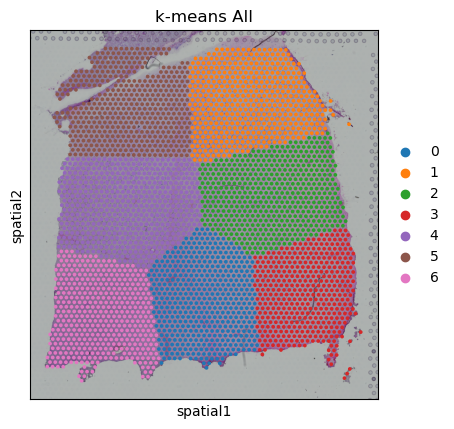

In [9]:
# run k-means clustering algorithm
kmeans_count_spatial = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(pdata)

# get labels
adata.obs['k-means All'] = kmeans_count_spatial.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["k-means All"])

Well. This tells us that the clustering algorithm puts in all its consideration with the spatial location. This is because the spatial locations are on a different order of magnitude in its variance compared to the counts. We z-score normalize the location data.

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\324361352.py:13: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["k-means All"])


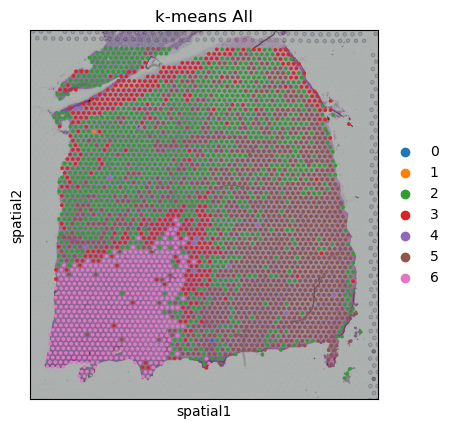

In [10]:
# perform z-score normalization
pdata_spatial_norm = pdata.copy()
pdata_spatial_norm['x'] = (pdata['x'] - np.mean(pdata['x']))/np.std(pdata['x'])
pdata_spatial_norm['y'] = (pdata['y'] - np.mean(pdata['y']))/np.std(pdata['y'])

# run k-means clustering algorithm
kmeans_count_spatial = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(pdata_spatial_norm)

# get labels
adata.obs['k-means All'] = kmeans_count_spatial.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["k-means All"])

Much better! We find the adjusted Rand index for this clustering.

In [11]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['k-means All'])

0.17514606530069785

For the sake of comparison, we take a look at what the clustering looks like without spatial information.

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\1521790290.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["k-means Count"])


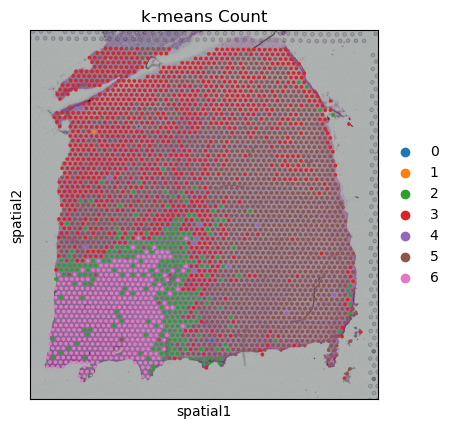

In [12]:
# run k-means clustering algorithm
kmeans_count = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(pdata_spatial_norm.iloc[:,:21312])

# get labels
adata.obs['k-means Count'] = kmeans_count.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["k-means Count"])

This is worse than without spatial data, as can be seen with the greater heterogeneity in the layer on the bottom left.

In [13]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['k-means Count'])

0.16780391119450905

## Section 2.2: Hierarchical Clustering

We now try hierarchical clustering on all the data. There are several types within hierarchical clustering, but we will choose `AgglomerativeClustering`. Again, we start by trying clustering on both count and spatial data. We use the z-score normalized spatial data.

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\3708491760.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["Hierarchical All"])


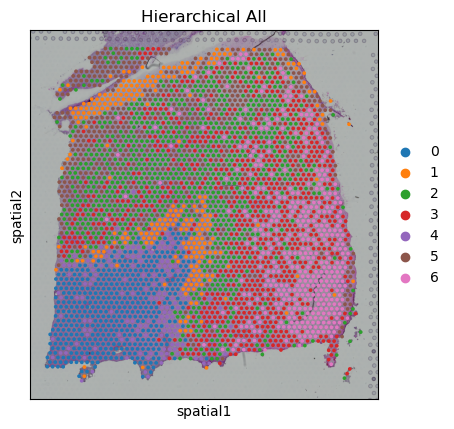

In [14]:
# run hierarchical clustering algorithm
hierarchical_count_spatial = AgglomerativeClustering(n_clusters=7).fit(pdata_spatial_norm)

# get labels
adata.obs['Hierarchical All'] = hierarchical_count_spatial.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["Hierarchical All"])

In [15]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['Hierarchical All'])

0.18213740009480547

This is marginally better than $k$-means clustering, but we still do not see the stratification of layers found in the ground truth. Again, for the sake of comparison, we see what happens without spatial information.

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\3005859703.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["Hierarchical Count"])


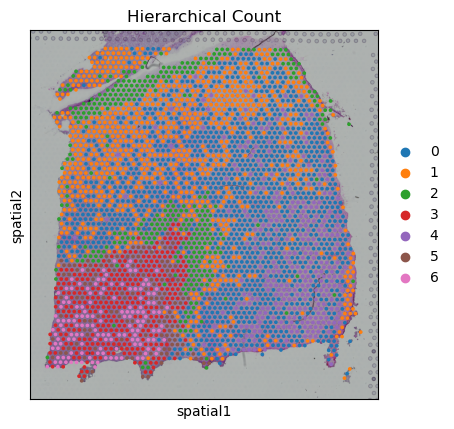

In [16]:
# run hierarchical clustering algorithm
hierarchical_count = AgglomerativeClustering(n_clusters=7).fit(pdata_spatial_norm.iloc[:,:21312])

# get labels
adata.obs['Hierarchical Count'] = hierarchical_count.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["Hierarchical Count"])

In [17]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['Hierarchical Count'])

0.13895735300330864

Clearly, these basic models are insufficient. We will most likely have to handle dropouts better; the sparsity of the dataset is doing us no favors. Before that, let us see if reduction of dimensionality helps.

## Section 2.3: Dimensionality Reduction

### Section 2.3.1: PCA

We first try a linear dimensionality reduction method. Per the tip in the project instructions, Euclidean distances are not as useful a metric in high-dimensional data. The idea is to condense the 21312 remaining transcripts into a few dimensions to better run the clustering algorithm. We will select the number of dimensions needed to keep 95% of the variance.

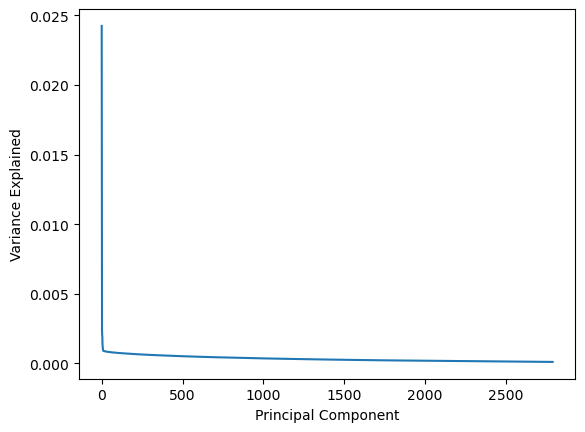

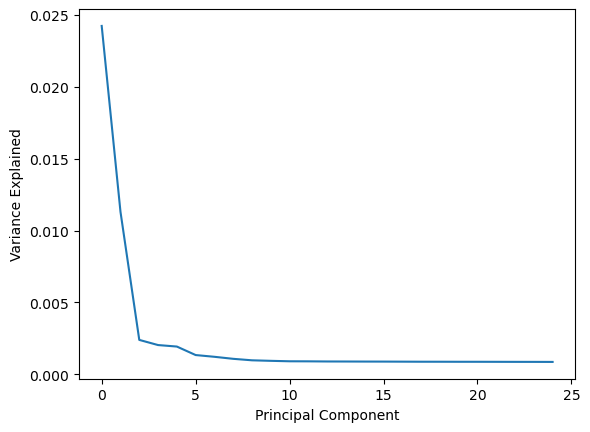

There are 2791 PC components.
The first PC dimension accounts for 0.024244076 of the variance.
The second PC dimension accounts for 0.011303038 of the variance.


In [18]:
ndata_count = pdata.iloc[:,:21312].to_numpy()
count_PCA = PCA(n_components=0.95).fit(ndata_count)
count_PC_space = count_PCA.transform(ndata_count)

plt.plot(count_PCA.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

plt.plot(count_PCA.explained_variance_ratio_[0:25])
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print('There are', np.shape(count_PCA.explained_variance_ratio_)[0], 'PC components.')
print('The first PC dimension accounts for', count_PCA.explained_variance_ratio_[0], 'of the variance.')
print('The second PC dimension accounts for', count_PCA.explained_variance_ratio_[1], 'of the variance.')

Because the individual PC components (even the first few) account for very little of the variance by themselves, we will use all 2791 components in our clustering.

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\1962310167.py:12: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["PCA k-means All"])


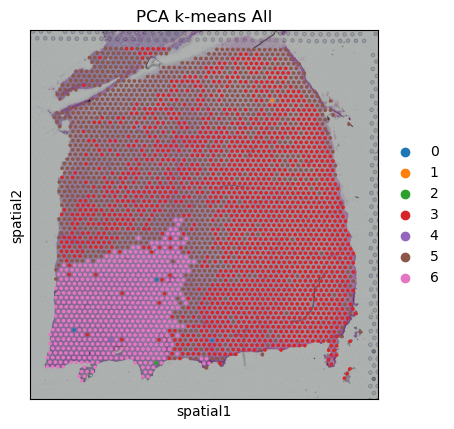

In [19]:
# combine PC-transformed data with z-score normalized data
count_PC_space_spatial = np.append(count_PC_space, np.atleast_2d(pdata_spatial_norm['x'].to_numpy()).T, axis=1)
count_PC_space_spatial = np.append(count_PC_space_spatial, np.atleast_2d(pdata_spatial_norm['y'].to_numpy()).T, axis=1)

# run k-means clustering algorithm
kmeans_count_PC_spatial = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(count_PC_space_spatial)

# get labels
adata.obs['PCA k-means All'] = kmeans_count_PC_spatial.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["PCA k-means All"])

In [20]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['PCA k-means All'])

0.17533937065951816

Performance increases very negligibly. We now try hierarchical clustering.

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\3896943138.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["PCA Hierarchical All"])


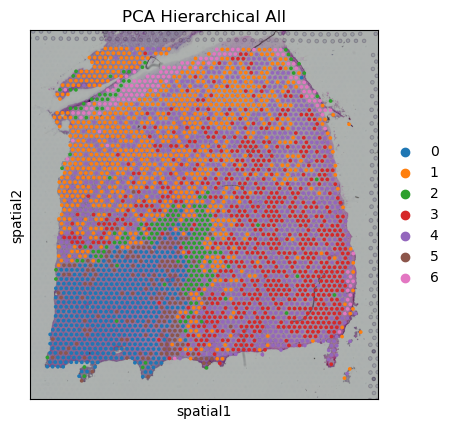

In [21]:
# run hierarchical clustering algorithm
hierarchical_count_PC_spatial = AgglomerativeClustering(n_clusters=7).fit(count_PC_space_spatial)

# get labels
adata.obs['PCA Hierarchical All'] = hierarchical_count_PC_spatial.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["PCA Hierarchical All"])

In [22]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['PCA Hierarchical All'])

0.16868440072756638

This is not much better. We now try some nonlinear dimensionality reduction techniques. Perhaps these are better able to tease out neighbors in our sparse high-dimensional dataset.

### Section 2.3.2: t-SNE

We begin with t-SNE. The trick with these nonlinear methods is that there is no good way to know how many components to pick. Unfortunately, we can only really choose from 2 or 3 components; the limit for the `barnes_hut` algorithm used by `sklearn`'s `TSNE` command is 3 components. (We could switch to the exact algorithm, but the run time would be excessively long.) After trying both 2 and 3 components, separation is actually better for 2 components.

What t-SNE emphasizes is local distances; the main difference between t-SNE and UMAP is that t-SNE should not be interpreted for global distances (such as the distance between clusters).

In [23]:
count_tSNE = TSNE(n_components=2).fit(ndata_count)
count_tSNE_space = count_tSNE.fit_transform(ndata_count)

To visualize how t-SNE reduces the dimensionality of the data, we need to first create an array of the layers of the cells.

In [24]:
cell_layers = adata.obs['Ground Truth'].to_numpy()
cell_layers[cell_layers == 'WM'] = 7
for i in range(len(cell_layers)):
    if isinstance(cell_layers[i], str):
        cell_layers[i] = int(cell_layers[i][-1])

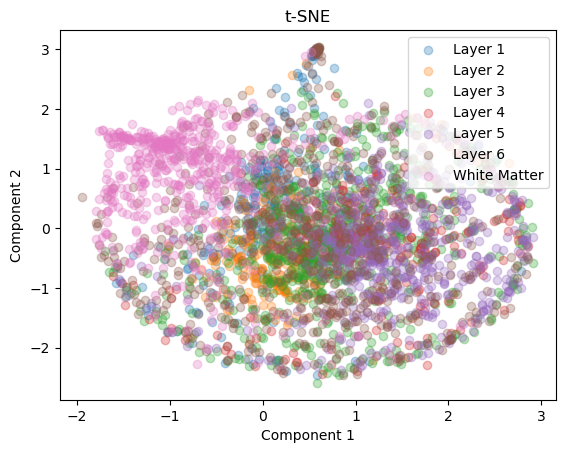

In [25]:
for i in range(7):
    plt.scatter(count_tSNE_space[cell_layers == i+1,0], count_tSNE_space[cell_layers == i+1,1], alpha=0.3)
plt.legend(('Layer 1','Layer 2','Layer 3', 'Layer 4', 'Layer 5', 'Layer 6', 'White Matter'))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE')
plt.show()

This is not very promising; we do not see much separation of clusters, although the white matter seems to be pushed off to one side. We can perhaps hope that adding the spatial data allows the clustering to work a little better.

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\363648880.py:12: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["t-SNE k-means All"])


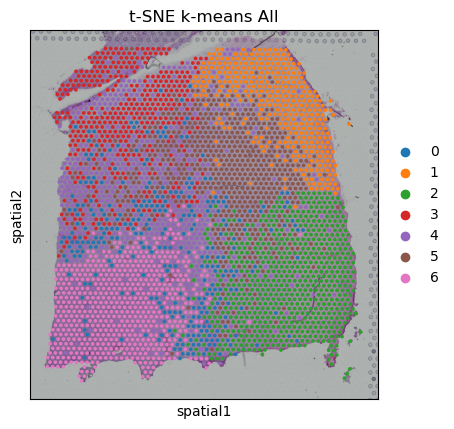

In [26]:
# combine t-SNE-transformed data with z-score normalized data
count_tSNE_space_spatial = np.append(count_tSNE_space, np.atleast_2d(pdata_spatial_norm['x'].to_numpy()).T, axis=1)
count_tSNE_space_spatial = np.append(count_tSNE_space_spatial, np.atleast_2d(pdata_spatial_norm['y'].to_numpy()).T, axis=1)

# run k-means clustering algorithm
kmeans_count_tSNE_spatial = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(count_tSNE_space_spatial)

# get labels
adata.obs['t-SNE k-means All'] = kmeans_count_tSNE_spatial.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["t-SNE k-means All"])

In [27]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['t-SNE k-means All'])

0.20843195595107192

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\2896330196.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["t-SNE Hierarchical All"])


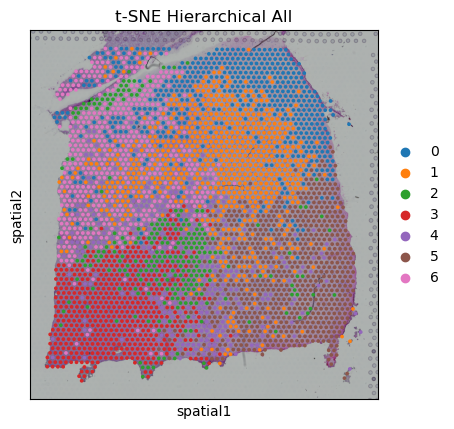

In [28]:
# run hierarchical clustering algorithm
hierarchical_count_tSNE_spatial = AgglomerativeClustering(n_clusters=7).fit(count_tSNE_space_spatial)

# get labels
adata.obs['t-SNE Hierarchical All'] = hierarchical_count_tSNE_spatial.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["t-SNE Hierarchical All"])

In [29]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['t-SNE Hierarchical All'])

0.18364317932524502

Regardless of using $k$-means or hierarchical clustering, t-SNE performs about the same as PCA.

### Section 2.3.3: UMAP

As mentioned above, UMAP tries to maintain both local and global distances. We see if that approach helps us.

Like t-SNE, we tested both 2 and 3 components for UMAP. Separation appears to be better for 3 components, so we use that for UMAP.

In [30]:
count_UMAP_space = umap.UMAP(n_components=3).fit_transform(ndata_count)

Once again, we plot the UMAP-reduced data to see if the clusters are clustered well. Although we reduce the data down to 3 components, we plot only the first 2 on a flat 2D graph.

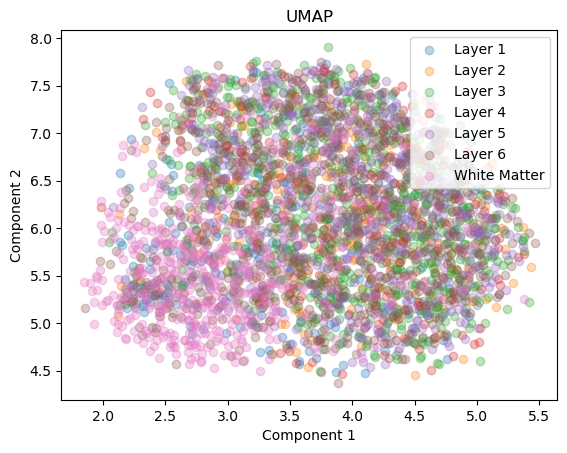

In [31]:
for i in range(7):
    plt.scatter(count_UMAP_space[cell_layers == i+1,0], count_UMAP_space[cell_layers == i+1,1], alpha=0.3)
plt.legend(('Layer 1','Layer 2','Layer 3', 'Layer 4', 'Layer 5', 'Layer 6', 'White Matter'))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('UMAP')
plt.show()

Once again, the only obvious cluster is white matter, and even then, the separation is not good. We see if adding spatial information helps. 

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\308022545.py:12: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["UMAP k-means All"])


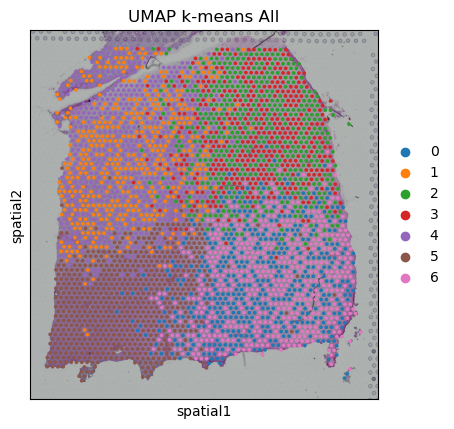

In [32]:
# combine UMAP-transformed data with z-score normalized data
count_UMAP_space_spatial = np.append(count_UMAP_space, np.atleast_2d(pdata_spatial_norm['x'].to_numpy()).T, axis=1)
count_UMAP_space_spatial = np.append(count_UMAP_space_spatial, np.atleast_2d(pdata_spatial_norm['y'].to_numpy()).T, axis=1)

# run k-means clustering algorithm
kmeans_count_UMAP_spatial = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(count_UMAP_space_spatial)

# get labels
adata.obs['UMAP k-means All'] = kmeans_count_UMAP_spatial.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["UMAP k-means All"])

In [33]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['UMAP k-means All'])

0.14873414296766455

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\2163765582.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["UMAP Hierarchical All"])


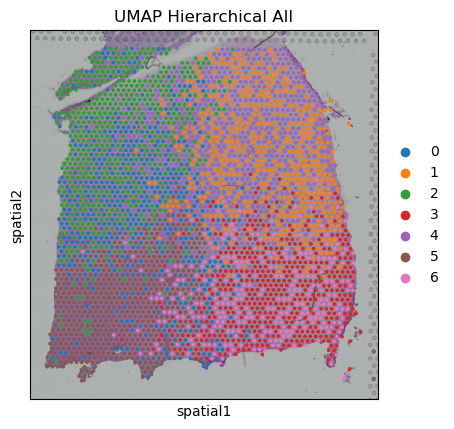

In [34]:
# run hierarchical clustering algorithm
hierarchical_count_UMAP_spatial = AgglomerativeClustering(n_clusters=7).fit(count_UMAP_space_spatial)

# get labels
adata.obs['UMAP Hierarchical All'] = hierarchical_count_UMAP_spatial.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["UMAP Hierarchical All"])

In [35]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['UMAP Hierarchical All'])

0.1331180798278976

UMAP also does not do that well.

### Section 2.3.4: Isomap

Although many nonlinear dimensionality reduction methods exist, Isomap will be the last one we test. In effect, Isomap focuses more on global distances, and may end up distorting more local distances.

In [36]:
count_Isomap = Isomap(n_components=2).fit(ndata_count)
count_Isomap_space = count_Isomap.fit_transform(ndata_count)

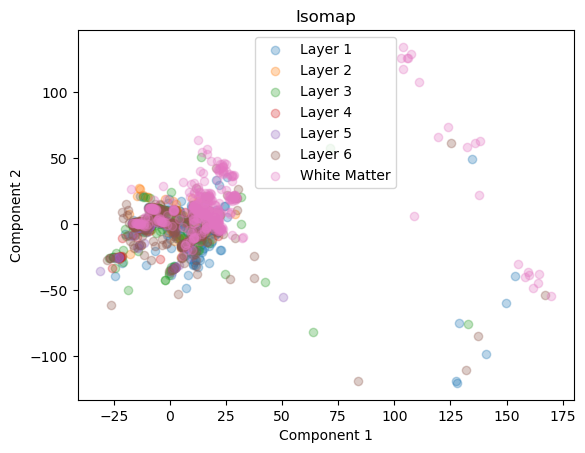

In [37]:
for i in range(7):
    plt.scatter(count_Isomap_space[cell_layers == i+1,0], count_Isomap_space[cell_layers == i+1,1], alpha=0.3)
plt.legend(('Layer 1','Layer 2','Layer 3', 'Layer 4', 'Layer 5', 'Layer 6', 'White Matter'))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Isomap')
plt.show()

This does not appear very promising. There seems to be many "outliers," especially the white matter, and separation of groups is not evident.

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\979791613.py:12: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["Isomap k-means All"])


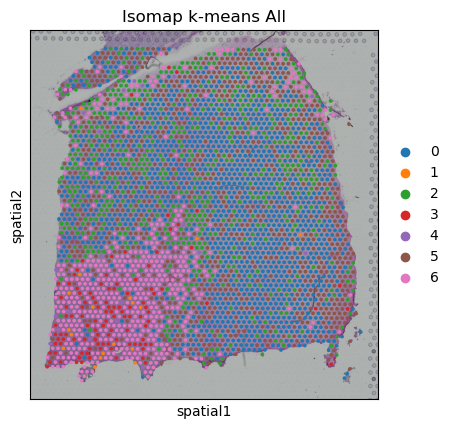

In [38]:
# combine Isomap-transformed data with z-score normalized data
count_Isomap_space_spatial = np.append(count_Isomap_space, np.atleast_2d(pdata_spatial_norm['x'].to_numpy()).T, axis=1)
count_Isomap_space_spatial = np.append(count_Isomap_space_spatial, np.atleast_2d(pdata_spatial_norm['y'].to_numpy()).T, axis=1)

# run k-means clustering algorithm
kmeans_count_Isomap_spatial = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(count_Isomap_space_spatial)

# get labels
adata.obs['Isomap k-means All'] = kmeans_count_Isomap_spatial.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["Isomap k-means All"])

In [39]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['Isomap k-means All'])

0.10106758401410768

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\699191299.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["Isomap Hierarchical All"])


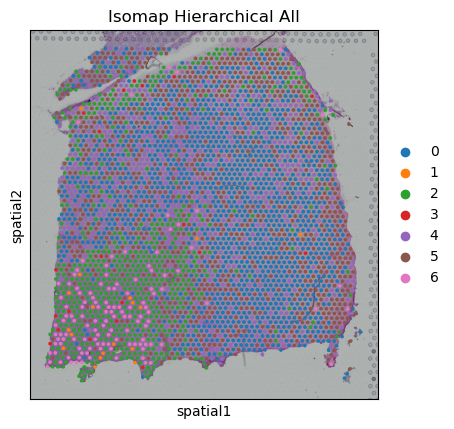

In [40]:
# run hierarchical clustering algorithm
hierarchical_count_Isomap_spatial = AgglomerativeClustering(n_clusters=7).fit(count_Isomap_space_spatial)

# get labels
adata.obs['Isomap Hierarchical All'] = hierarchical_count_Isomap_spatial.labels_.astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["Isomap Hierarchical All"])

In [41]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['Isomap Hierarchical All'])

0.097556041700484

Isomap performs worst of all these methods.

## Section 2.4: Gaussian Mixture Models and Combinations of Dimensionality Reduction

Next, we take a trip outside of this Jupyter notebook. In the folder labeled `Dimensionality_Reduction`, we try a different clustering method, Gaussian mixture models, as well as rerun $k$-means. Here, we rely on R to implement `mclust`, which fits 7 Gaussian models that best fit the density of the data. However, we find that without dimensionality reduction (`no_dimensionality_reduction.py`), we exceed the memory limit of our computer, and we do not get an adjusted Rand index as a result.

To get around this, we need to reduce the dimensionality of our dataset. We do this with some of the ways we did above: PCA (`PCA.py`), t-SNE (`tSNE.py`), and UMAP (`UMAP.py`). However, we also go one step further and experiment with linearly reducing the data with PCA first, followed by either t-SNE (`PCA_and_tSNE.py`) or UMAP (`PCA_and_UMAP.py`). The adjusted Rand indices are summarized in the table below. For PCA followed by t-SNE, different values of perplexity were tested, and the best results are reported below.

| Method | mclust | $k$-means |
| --- | --- | --- |
| PCA | 0.31 | 0.17 |
| t-SNE | 0.28 | 0.29 |
| UMAP | 0.28 | 0.31 |
| PCA and t-SNE | 0.30 | 0.27 |
| PCA and UMAP | 0.34 | 0.27 |

Notice that the $k$-means do not necessarily match the results from earlier, like t-SNE. This is due to the stochastic nature of the algorithm.

# Section 3: Alternative Distance Measures

## Section 3.1: Cosine Distance

Thus far, our methods have relied on Euclidean distances. However, we now turn to cosine distances to see if this does any better. Since PCA followed by UMAP had the best results in the previous subsection, we now tell UMAP to use the cosine distances, rather than the Euclidean distances, to see if this improves results (`Dimensionality_Reduction/PCA_UMAP_cosine.py`).

For `mclust`, we get an adjusted Rand index of 0.27, and $k$-means yields 0.23. This is actually worse than the Euclidean distances. One theory as to why this is the case is that using cosine distances may not preserve the Gaussianity of the density, making it such that `mclust` is not able to find good Gaussian clusters.

## Section 3.2: $\rho_p$ and $\phi_s$

As mentioned in the project description and existing literature ([Skinnider et al. 2019](https://www.nature.com/articles/s41592-019-0372-4)), Euclidean distance is rather unhelpful for single-cell RNA data. Two measures that are found to perform well are $\rho_p$ (a proportionality correlation) and $\phi_s$ (a symmetric proportionality), which come from `propr`, an R package documented in [Quinn et al. 2017](https://www.nature.com/articles/s41598-017-16520-0).

Strictly speaking, these are not distance measures, but something more like correlation. However, we can use these measures to cluster the cells since they tell us how "proportional" different cells are.

For this section, we move out of Python into R. While we can call R from Python, it is easiest to just run the following code directly in R. However, we need to export the transcript counts out of Python into a .csv file to be loaded in R. Later, we export the resulting $\rho_p$ and $\phi_s$ from R as .csv to import into this notebook.

In [42]:
# export cleaned cell counts
adata_raw.to_df().loc[:,np.invert(empty_transcripts)].to_csv('data/cell_counts.csv')

```
# install propr if not yet installed
# install.packages("remotes")
# remotes::install_github("tpq/propr")

# load in propr
library(propr)


counts <- read.csv("data/cell_counts.csv")
rownames(counts) <- counts$X
counts$X <- NULL

rho_p <- propr(t(counts), metric = 'rho')@matrix
write.csv(rho_p, "rho_p.csv", row.names=FALSE)

phi_s <- propr(t(counts), metric = 'phs')@matrix
write.csv(phi_s, "phi_s.csv", row.names=FALSE)
```

We now import the $\rho_p$ and $\phi_s$ matrices. We can directly use $\phi_s$ as a distance matrix: the distance between a cell and itself is 0, and a larger value indicates that the cells are farther apart. However, we do need to adjust $\rho_p$ since it is more like a correlation, ranging from -1 to 1. To convert this to distances, we take $1 - \lvert \rho_p \rvert$.

In [43]:
rho_p = pd.read_csv('data/rho_p.csv')
phi_s = pd.read_csv('data/phi_s.csv')

In [44]:
rho_p_distances = 1 - abs(rho_p.copy())
rho_p_distances

AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  AAACACCAATAACTGC-1  \
0               0.000000            0.976888            0.971125   
1               0.976888            0.000000            0.915218   
2               0.971125            0.915218            0.000000   
3               0.902711            0.995091            0.927744   
4               0.925927            0.858511            0.932714   
...                  ...                 ...                 ...   
3455            0.937214            0.945928            0.950025   
3456            0.904276            0.944660            0.727200   
3457            0.848649            0.810432            0.787254   
3458            0.739042            0.692369            0.996271   
3459            0.941591            0.824754            0.952948   

      AAACAGAGCGACTCCT-1  AAACAGGGTCTATATT-1  AAACATTTCCCGGATT-1  \
0               0.902711            0.925927            0.958320   
1               0.995091            0.858511            0.881722   
2               0.927744            0.932714            0.983402   
3               0.000000            0.903358            0.959598   
4               0.903358            0.000000            0.897752   
...                  ...                 ...                 ...   
3455            0.982883            0.934582            0.967308   
3456            0.879129            0.789191            0.906198   
3457            0.854765            0.748013            0.854196   
3458            0.836025            0.674459            0.794710   
3459            0.967359            0.858687            0.907233   

      AAACCCGAACGAAATC-1  AAACCGGGTAGGTACC-1  AAACCGTTCGTCCAGG-1  \
0               0.878417            0.902927            0.869615   
1               0.862314            0.862382            0.895196   
2               0.952584            0.954552            0.763976   
3               0.961670            0.940214            0.848144   
4               0.852572            0.822117            0.805629   
...                  ...                 ...                 ...   
3455            0.893855            0.907350            0.895192   
3456            0.802634            0.835922            0.577498   
3457            0.762969            0.744269            0.600974   
3458            0.642147            0.621180            0.605349   
3459            0.835600            0.806036            0.884936   

      AAACCTAAGCAGCCGG-1  ...  TTGTGGTGGTACTAAG-1  TTGTGTATGCCACCAA-1  \
0               0.874884  ...            0.965957            0.829696   
1               0.812905  ...            0.961246            0.810923   
2               0.949577  ...            0.994829            0.945001   
3               0.918850  ...            0.973921            0.872732   
4               0.810471  ...            0.994557            0.740354   
...                  ...  ...                 ...                 ...   
3455            0.900812  ...            0.990013            0.882491   
3456            0.794293  ...            0.981041            0.697949   
3457            0.722144  ...            0.966608            0.632931   
3458            0.601238  ...            0.985058            0.474069   
3459            0.796922  ...            0.980877            0.786266   

      TTGTGTTTCCCGAAAG-1  TTGTTAGCAAATTCGA-1  TTGTTCAGTGTGCTAC-1  \
0               0.906533            0.987377            0.931483   
1               0.868284            0.882011            0.839792   
2               0.884667            0.940798            0.959408   
3               0.937236            0.990185            0.982601   
4               0.828267            0.944014            0.890057   
...                  ...                 ...                 ...   
3455            0.897010            0.969578            0.873700   
3456            0.742421            0.994120            0.894844   
3457            0.697190            0.958042            0.813292  

In [45]:
phi_s

AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  AAACACCAATAACTGC-1  \
0               0.000000            1.047318            1.059468   
1               1.047318            0.000000            1.185272   
2               1.059468            1.185272            0.000000   
3               0.822673            1.009867            1.155767   
4               1.159997            0.752098            0.873911   
...                  ...                 ...                 ...   
3455            1.133984            0.897403            1.105207   
3456            1.211715            0.895125            0.571339   
3457            1.356686            0.681282            0.649149   
3458            1.706205            0.529483            0.992569   
3459            1.124065            0.701772            1.098750   

      AAACAGAGCGACTCCT-1  AAACAGGGTCTATATT-1  AAACATTTCCCGGATT-1  \
0               0.822673            1.159997            0.919975   
1               1.009867            0.752098            1.268288   
2               1.155767            0.873911            1.033755   
3               0.000000            1.213962            0.922333   
4               1.213962            0.000000            1.227787   
...                  ...                 ...                 ...   
3455            1.034831            0.877198            1.067593   
3456            1.274979            0.651788            1.207023   
3457            1.339824            0.597461            1.341382   
3458            1.392274            0.508818            1.516640   
3459            1.067485            0.752367            1.204506   

      AAACCCGAACGAAATC-1  AAACCGGGTAGGTACC-1  AAACCGTTCGTCCAGG-1  \
0               0.783193            0.823032            1.299868   
1               1.319342            1.319158            0.810276   
2               1.099553            1.095224            0.618092   
3               0.926170            0.887173            1.358091   
4               1.345842            1.432745            0.674521   
...                  ...                 ...                 ...   
3455            1.237500            1.204222            0.810270   
3456            1.491795            1.392569            0.405974   
3457            1.621337            1.687201            0.429566   
3458            2.114550            2.219678            0.434051   
3459            1.393490            1.481279            0.793619   

      AAACCTAAGCAGCCGG-1  ...  TTGTGGTGGTACTAAG-1  TTGTGTATGCCACCAA-1  \
0               0.777594  ...            0.934156            1.410520   
1               1.460311  ...            1.080632            0.681977   
2               1.106201  ...            0.989712            0.895737   
3               0.849882  ...            1.053555            1.291655   
4               1.467699  ...            0.989173            0.587748   
...                  ...  ...                 ...                 ...   
3455            1.220220  ...            1.020176            0.789695   
3456            1.517961  ...            1.038651            0.536039   
3457            1.769532  ...            1.069092            0.462983   
3458            2.326472  ...            1.030336            0.310675   
3459            1.509657  ...            1.038991            0.647808   

      TTGTGTTTCCCGAAAG-1  TTGTTAGCAAATTCGA-1  TTGTTCAGTGTGCTAC-1  \
0               1.206207            0.975069            1.147115   
1               0.767228            0.788927            0.723828   
2               0.793187            1.125854            1.084620   
3               1.133935            1.019825            1.035414   
4               0.706874            0.893964            0.801894   
...                  ...                 ...                 ...   
3455            0.813253            0.940952            0.775726   
3456            0.590358            0.988308            0.809700   
3457            0.535144            0.919463            0.685335  

We can now cluster. We can really only use hierarchical clustering since we do not have points in a hyperplane as is needed for $k$-means.

Notice that the process for hierarchical clustering is a little different because we have the distance matrix computed. From the distance matrix, we calculate a linkage matrix, which can be used to plot a dendogram. We use the same settings as the default settings for `AgglomerateClustering` as before, which is using the Ward method. From this, we then apply the clustering.

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\3994168464.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["Hierarchical Rho"])


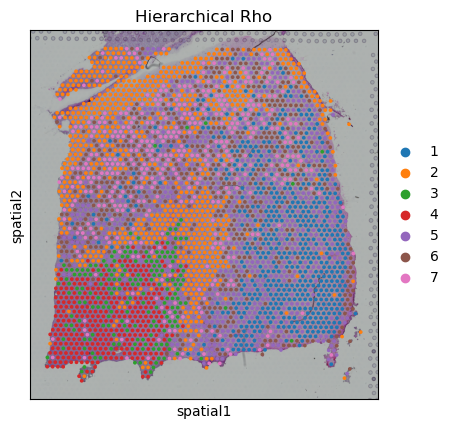

In [46]:
# calculate linkage
rho_linkage = linkage(squareform(rho_p_distances, checks=False), method='ward')

# set cluster labels
adata.obs['Hierarchical Rho'] = fcluster(rho_linkage, t=7, criterion='maxclust').astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["Hierarchical Rho"])

In [47]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['Hierarchical Rho'])

0.137005000546506

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17224\1509407818.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["Hierarchical Phi"])


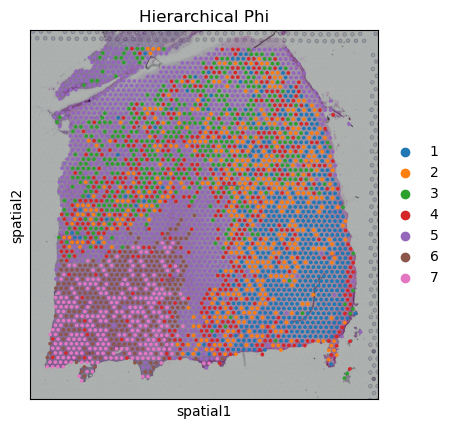

In [48]:
# calculate linkage
phi_linkage = linkage(squareform(phi_s, checks=False), method='ward')

# set cluster labels
adata.obs['Hierarchical Phi'] = fcluster(phi_linkage, t=7, criterion='maxclust').astype(str)

# plot
sc.pl.spatial(adata, img_key="hires", color=["Hierarchical Phi"])

In [49]:
obs_df = adata.obs.dropna()
adjusted_rand_score(obs_df['Ground Truth'], obs_df['Hierarchical Phi'])

0.15308011963091878

To be honest, this is rather disappointing. It seemed that $\rho_p$ and $\phi_s$ would perform well from the literature. Alas, it is not so with this set of data. To be fair, the $\rho_p$ and $\phi_s$ do not use the spatial data at all, so the fact that it is able to get some degree of layering spatially is remarkable.

We turn now to data imputation, which can hopefully solve many of these problems.

# Section 4: Data Imputation

## Section 4.1: VIPER

The first data imputation method we try is  Variability-Preserving ImPutation for Expression Recovery (VIPER) ([Chen & Zhou (2018))](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1575-1)). VIPER essentially uses linear regression to predict the true value of zero counts. Specifically, they apply LASSO regression, which utilizes the $\ell_1$ norm as a penalty. In effect, this induces sparsity in which neighboring cells to use in the prediction of counts. Not all neighboring cells provide useful information on what the expression count for the cell of interest is; this method ensures that we only look at the cells that provide more inferential power.

The code is found in `VIPER.py`. We compare the results in the table below.

| Method | No Imputation | VIPER |
| --- | --- | --- |
| mclust | 0.31 | 0.39 |
| $k$-means | 0.18 | 0.25 |

We do see a marked improvement, one beyond what we have seen in previous results.

## Section 4.2: MAGIC

We examine Markov Affinity-based Graph Imputation of Cells (MAGIC) ([van Dijk et al. (2018)](https://www.cell.com/cell/fulltext/S0092-8674(18)30724-4)). The math behind MAGIC is far beyond the scope of the course, but it essentially looks for cells with similar expression profiles and uses an exponentially decaying similarity to heavily weight the most transcriptomically similar cells. They also implement Markov chains in data diffusion to remove the effect of noise.

Using MAGIC, followed by PCA and UMAP, and then $k$-means clustering (`PCA_kmeans_UMAP_spatialsmoothing.py`) yields an adjusted Rand index of 0.22.

## Section 4.3: Spatial Smoothing

Because MAGIC does not take spatial information into account, spatial smoothing is also investigated. Neighbors are found from the coordinates and embedded into a sparse "connectivity" matrix. Here, a simple convolutional filter to average neighbors is used. Weights ranging from 0.1 to 1 are used.

Applying MAGIC, spatial smoothing, PCA, UMAP, and $k$-means clustering (`PCA_kmeans_UMAP_spatialsmoothing.py`) yields an adjusted Rand index of 0.37.